In [26]:
import sys
sys.path.insert(0, "/home/emmanuel/projects/2019_sakame")

# Standard Python Libraries
import numpy as np

# Data functions
from dataclasses import dataclass
from src.data.make_dataset import get_class_data

# ML Model Functions
from src.models.classification import svm_naive
# from src.models.derivatives import svm_rbf_derivative

# Visualization Functions
from src.visualization.utils import create_grid
from src.visualization.classification import plot_toy_data, plot_predictions, plot_sensitivity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Experiment Params

In [76]:
@dataclass
class DemoParams:
    dataset = 'circles'
    num_points = 200
    num_training = .5
    noise_level = 0.01
    plots = "demo"
    random_state = None
    n_jobs = -1
    verbose = 1
    mask_param = 1.0
    grid_points = 100

### Data

In [77]:
Xdata, ydata = get_class_data(
    num_points=DemoParams.num_points,          
    num_training=DemoParams.num_training,                          
    noise=DemoParams.noise_level,                                        
    random_state=DemoParams.random_state,                                        
    data_set=DemoParams.dataset
)

### Visualize Toy Data

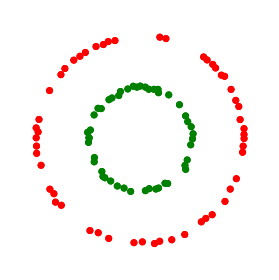

In [78]:
import matplotlib.pyplot as plt

# plot data
fig, ax = plot_toy_data(
    Xdata['train'],
    ydata['train'],
    Xdata['data']
)

# # remove ticks
# ax.set_xticks(())
# ax.set_yticks(())
# ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 1.0 Model (SVM Classifier)

### 1.1 - Train SVM Model

We will train an svm model that has been cross-validated to find the best parameters for the model.

In [117]:
y, svm_model = svm_naive(
    X_train=Xdata['train'],
    y_train=ydata['train'],
    X_test=Xdata['test'],
    n_grid=30
)

In [118]:
svm_model

SVC(C=0.6993103448275861, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.6993103448275861, kernel='rbf', max_iter=-1, probability=False,
    random_state=123, shrinking=True, tol=0.001, verbose=False)

### 1.2 - Visualize Predictions

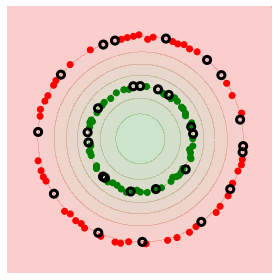

In [119]:
fig, ax = plot_predictions(
    xgrid=Xdata['data'],
    decision_function=svm_model.decision_function,
    support_vectors=svm_model.support_vectors_,
#     xtrain=Xdata['train'],
#     ytrain=ydata['train'],
    xtest=Xdata['test'],
    ytest=ydata['test']
)


plt.tight_layout()
plt.show()

## 2.0 - Sensitivity

We need to extract the support vectors and labels which we will need to calculate the derivative.

### 2.1 - Derivative

#### 2.1.1 - Decision Function

In [120]:
from src.models.derivatives import svm_decision_derivative
from sklearn.metrics.pairwise import rbf_kernel

In [121]:
x_plot = create_grid(Xdata['data'], 100)

# kernel matrix
K = rbf_kernel(x_plot, svm_model.support_vectors_, gamma=svm_model.gamma)

x_ders = svm_decision_derivative(
    X_test=x_plot, 
    weights=svm_model.dual_coef_.T, 
    K=K,
    bias=svm_model.intercept_,
    mask_param=1.0
)

assert x_ders.shape[0] == x_plot.shape[0]

sens = (x_ders**2).sum(axis=1)
x_ders.shape

(10000, 1)

##### Plot Sensitivity

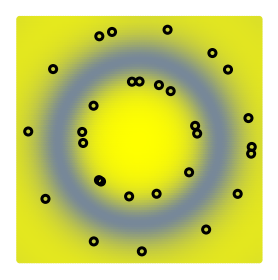

In [122]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=sens,
    support_vectors=svm_model.support_vectors_
)

plt.tight_layout()
plt.show()

#### 2.2 - Objective Function

In [123]:
from src.models.derivatives import svm_obj_derivative

In [124]:
x_plot = create_grid(Xdata['data'], 100)


# kernel matrix
K = rbf_kernel(x_plot, svm_model.support_vectors_, gamma=svm_model.gamma)

x_ders = svm_obj_derivative(
    X_test=x_plot, 
    weights=svm_model.dual_coef_.T, 
    K=K,
    bias=svm_model.intercept_,
    mask_param=1.0
)
assert x_ders.shape[0] == x_plot.shape[0]

sens = (x_ders**2).sum(axis=1)
x_ders.shape, sens.shape

((10000, 1), (10000,))

##### Plot Sensitivity

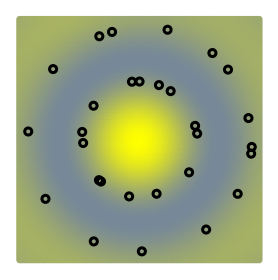

In [125]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=sens,
    support_vectors=svm_model.support_vectors_
)

plt.tight_layout()
plt.show()

#### 2.3 - Mask Function

In [126]:
from src.models.derivatives import svm_mask_derivative

In [127]:
x_plot = create_grid(Xdata['data'], 100)


# kernel matrix
K = rbf_kernel(x_plot, svm_model.support_vectors_, gamma=svm_model.gamma)

x_ders = svm_mask_derivative(
    X_test=x_plot, 
    weights=svm_model.dual_coef_.T, 
    K=K,
    bias=svm_model.intercept_,
    mask_param=1.0
)
assert x_ders.shape[0] == x_plot.shape[0]

sens = (x_ders**2).sum(axis=1)

x_ders.shape, sens.shape

((10000, 1), (10000,))

##### Plot Sensitivity

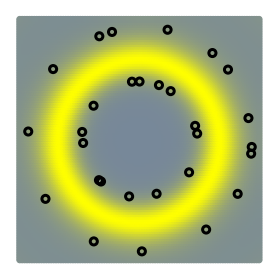

In [128]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=sens,
    support_vectors=svm_model.support_vectors_
)

plt.tight_layout()
plt.show()

#### 2.4 - Kernel Function

In [129]:
from src.models.derivatives import svm_rbf_derivative

In [130]:
svm_model.dual_coef_.T.shape, svm_model.support_.shape, K[0, :].shape

((29, 1), (29,), (29,))

In [131]:
x_plot = create_grid(Xdata['data'], 100)

# kernel matrix
K = rbf_kernel(x_plot, svm_model.support_vectors_, gamma=svm_model.gamma)

x_ders = svm_rbf_derivative(
    X_test=x_plot, 
    K=K,
    support_vectors=svm_model.support_vectors_, 
    weights=svm_model.dual_coef_.T, 
    y_labels=svm_model.support_,
    gamma=svm_model.gamma,
)
assert x_ders.shape == x_plot.shape

sens = (x_ders**2).sum(axis=1)

x_ders.shape, sens.shape

((10000, 2), (10000,))

##### Plot Sensitivity

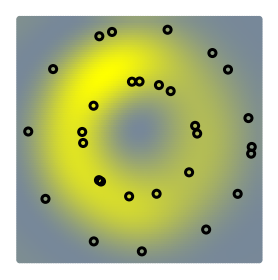

In [132]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=sens,
    support_vectors=svm_model.support_vectors_
)

plt.tight_layout()
plt.show()

#### 2.5 - Full Derivative

In [133]:
from src.models.derivatives import svm_full_derivative

In [134]:
x_plot = create_grid(Xdata['data'], 100)

# kernel matrix
K = rbf_kernel(x_plot, svm_model.support_vectors_, gamma=svm_model.gamma)

# Full Derivative
x_ders = svm_full_derivative(
    X_test=x_plot, 
    support_vectors=svm_model.support_vectors_, 
    K=K,
    weights=svm_model.dual_coef_.T, 
    y_labels=svm_model.support_,
    gamma=svm_model.gamma,
    bias=svm_model.intercept_,
    mask_param=1.0,
    
)

assert x_ders.shape == x_plot.shape

sens = (x_ders**2).sum(axis=1)

x_ders.shape, sens.shape

((10000, 2), (10000,))

##### Plot Sensitivity

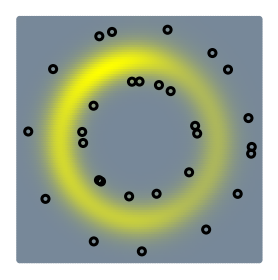

In [135]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=sens,
    support_vectors=svm_model.support_vectors_
)

plt.tight_layout()
plt.show()

### 2.2 - Calculate Sensitivity

In [19]:
sens = (x_ders ** 2).sum(axis=1)

In [74]:
# points needed for plotting
grid_points = 1_000
x_plot = create_grid(Xdata['train'], grid_points)

y_plot = svm_model.predict(x_plot)